## Netflix Movie Recommendation

### Business Problem

We want to recommend movies to users by
- By predicting the rating for a movie which has been unrated by the user
- Build a model with RMSE (between actual and predicted ratings) as the metric

The ratings prediction need not be calculated instantaneosly as these ratings would be precomputed on a daily basis (May be Nightly)

### Data

The dataset can be downloaded from https://www.kaggle.com/netflix-inc/netflix-prize-data

Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

Columns : __CustomerID, Rating, Date__

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

Movie information in "movie_titles.txt" is in the following format:

MovieID,YearOfRelease,Title

- MovieID do not correspond to actual Netflix movie ids or IMDB movie ids.
- YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release.
- Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English.

### ML Problem

If we pose this a ML problem,we can categorize it as :
- Recommendation Problem to Recommend Movies
- Regression task to predict the ratings for an unrated movie

### Importing Libraries

In [55]:
import pandas as pd
import numpy as np
import os
from itertools import islice
import re
from tqdm import tqdm_notebook
from datetime import datetime
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis

#### Data Preprocessing

In [2]:
# List all files 
for file in os.listdir('./data'):
    print('Filename: {0} --> {1}'.format(file.ljust(30).rstrip(),
                                       str(round(os.path.getsize('./data/'+file)/1000000,2))+'MB'))

Filename: .gitignore --> 0.0MB
Filename: .ipynb_checkpoints --> 0.0MB
Filename: all_data_combined.csv --> 2711.02MB
Filename: combined_data_1.txt --> 495.03MB
Filename: combined_data_2.txt --> 555.21MB
Filename: combined_data_3.txt --> 465.16MB
Filename: combined_data_4.txt --> 552.54MB
Filename: movie_titles.csv --> 0.58MB
Filename: probe.txt --> 10.78MB
Filename: qualifying.txt --> 52.45MB


In [3]:
# Sample Read
with open('./data/combined_data_1.txt') as file:
    head = list(islice(file,10))
print('First 10 rows: ......')
print([h for h in head])
file.close()

First 10 rows: ......
['1:\n', '1488844,3,2005-09-06\n', '822109,5,2005-05-13\n', '885013,4,2005-10-19\n', '30878,4,2005-12-26\n', '823519,3,2004-05-03\n', '893988,3,2005-11-17\n', '124105,4,2004-08-05\n', '1248029,3,2004-04-22\n', '1842128,4,2004-05-09\n']


In [4]:
# get all data files
files = [f for f in os.listdir('./data/') \
         if re.match('combined_data.*\.txt',f)]
files

['combined_data_1.txt',
 'combined_data_2.txt',
 'combined_data_3.txt',
 'combined_data_4.txt']

In [5]:
# Write a file with the final data
start_time = datetime.now()
if not os.path.isfile('./data/all_data_combined.csv'):
    all_data_combined = open('./data/all_data_combined.csv',mode = 'w')
# combine all the data into the format movieid','userid','rating','date'
    row = list()
    for file in tqdm(files):
        with open(os.path.join('./data/',file)) as f:
            for line in f:
                line = line.strip()
                if line.endswith(':'):
               # Then all that follow are ratings untill me revisit the same ':' pattern
                    movie_id = line.replace(':','')
                else:
                    row = [word for word in line.split(',')]
                    row.insert(0,movie_id)
                    all_data_combined.write(','.join(row))
                    all_data_combined.write('\n')
    all_data_combined.close()
    print('All data has been combined')
    print('Total Time Taken: {}'.format(datetime.now() - start_time))
                

#### Create a dataframe from the combined data

In [6]:
df = pd.read_csv('./data/all_data_combined.csv',sep = ',',names = ['movie','user','rating','date'])
df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


#### Sort the data

In [7]:
# lets sort the data by the data
df.sort_values(by='date',inplace=True)
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 4 columns):
movie     int64
user      int64
rating    int64
date      object
dtypes: int64(3), object(1)
memory usage: 3.7+ GB


In [9]:
df.describe()

,movie,user,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


#### Check for any NaN values


In [10]:
df.isnull().sum()

movie     0
user      0
rating    0
date      0
dtype: int64

#### find duplicates, if any.

In [11]:
boolean = any(df.duplicated(subset=['movie','user','rating'])) 
boolean

False

There are no duplicates

#### Unique Records

In [12]:
print('Total unique users : ',df.user.nunique())
print('Total unique movies : ',df.movie.nunique())
print('Total ratings : ',df.shape[0])

Total unique users :  480189
Total unique movies :  17770
Total ratings :  100480507


#### Train/ Test Split

- As we have sorted the data in ascending order of dates, we will have the oldest ratings at the top and latest rating at the end.
- Here, we need to make use of the data's temporal (time) nature. We will use the older data everytime to make predictions for the future.
- The ratings model would be trained frequently on current day to day data and used to infer ratings for the future

In [13]:
%%timeit
if not os.path.isfile('./data/train.csv'):
    # First 80 % 
    train = df.iloc[:int(len(df)*0.80)]
    train.to_csv('./data/train.csv',index = False)
if not os.path.isfile('./data/test.csv'):
    # Remaining 20 %
    test = df.iloc[int(len(df)*0.80):]
    test.to_csv('./data/test.csv',index = False)


166 µs ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
train_df = pd.read_csv("./data/train.csv",parse_dates = ['date'])

In [21]:
test_df = pd.read_csv("./data/test.csv",parse_dates = ['date'])

#### Check the distribution of the ratings in Train set

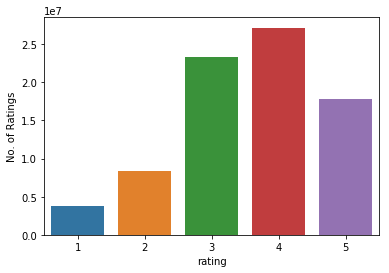

In [24]:
sns.countplot(train_df.rating)
plt.ylabel('No. of Ratings')
plt.show()

Most people rate 3 & 4. Very few people rate a movie as low as 1

We will add a column called a day_of_week and see if it can used to infer ratings

In [25]:
train_df['day_of_week'] = train_df.date.dt.weekday_name
train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


#### Ratings per user

In [34]:
ratings_per_user_df = train_df.groupby(['user'])['rating'].count().sort_values(ascending=False)

ratings_per_user_df.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

A user has rated 17,112 times !

##### Plot the ratings per user in a PDF / CDF plot

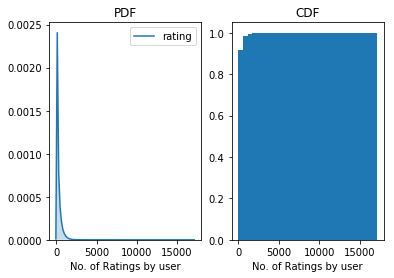

In [51]:
ax1 = plt.subplot(121)
sns.kdeplot(ratings_per_user_df,shade = True,ax = ax1)
plt.xlabel("No. of Ratings by user")
plt.title('PDF')

ax2 = plt.subplot(122)
plt.hist(ratings_per_user_df,cumulative=True, density=True, bins=30)

plt.xlabel("No. of Ratings by user")
plt.title('CDF')

plt.show()

Most users only rate a few movies

#### Ratings by day of the week

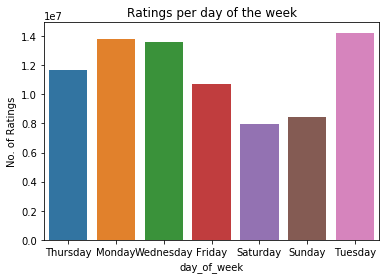

In [52]:
sns.countplot(train_df.day_of_week)
plt.ylabel('No. of Ratings')
plt.title('Ratings per day of the week')
plt.show()

Saturdays and Sundays have the least ratings in numbers as people tend to spend time outdoors

##### Box plot for ratings by the day of the week

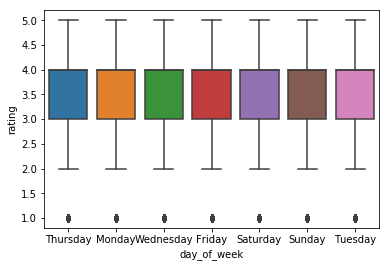

In [54]:
sns.boxplot(x= 'day_of_week', y = 'rating', data = train_df)
plt.show()

No , the feature day_of_week doesn't help us in ientifying a rating given by a user for a movie

#### Create Sparse Matrix for the users and ratings

In [59]:
start = datetime.now()
if not os.path.isfile('./data/train_sparse.npz'):
    print('Creating Sparse Matrix for Training Data')
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values,(train_df.user.values,train_df.movie.values)),)
    print('Done: Shape of matrix : ',train_sparse_matrix.shape)
end = datetime.now()

print('Time taken : {}'.format(end-start))

Creating Sparse Matrix for Training Data
Done: Shape of matrix :  (2649430, 17771)
Time taken : 0:00:16.871051
